In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, r2_score


# Configure display options
sns.set(style="whitegrid")


In [17]:
# Load the dataset
kc_house_data = pd.read_csv("C:/Users/EWURA/Downloads/Stat 563 Project/kc_house_data.csv")

# Display the first few rows
kc_house_data.head()

# Check the structure of the dataset
kc_house_data.info()

# Summary statistics
kc_house_data.describe()

# Check for missing values
missing_values = kc_house_data.isnull().sum()
print(missing_values)

# Check for duplicate rows
duplicate_rows = kc_house_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [18]:
# Convert 'date' to datetime
kc_house_data['date'] = pd.to_datetime(kc_house_data['date'])

# Add year and month columns
kc_house_data['year_sold'] = kc_house_data['date'].dt.year
kc_house_data['month_sold'] = kc_house_data['date'].dt.month

# Group yr_built into decades
kc_house_data['decade_built'] = (kc_house_data['yr_built'] // 10) * 10


In [19]:

# Remove 'id' and 'date' columns
kc_house_data.drop(columns=["id", "date"], inplace=True)

# Define predictors (X) and response (y)
X = kc_house_data.drop(columns=["price"])
y = kc_house_data["price"]

# Add a constant term for intercept in the model
X = sm.add_constant(X)

# Fit the full linear regression model
model_full = sm.OLS(y, X).fit()

# Summary of the full model
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2536.
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:07:34   Log-Likelihood:            -2.9456e+05
No. Observations:               21613   AIC:                         5.892e+05
Df Residuals:                   21592   BIC:                         5.893e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.828e+07   9.94e+06     -6.869

In [20]:
# Remove extreme values for 'bedrooms' and 'sqft_lot'
kc_house_data = kc_house_data[(kc_house_data['bedrooms'] <= 10) &
                               (kc_house_data['sqft_lot'] < kc_house_data['sqft_lot'].quantile(0.99))]

# IQR filtering for 'price'
Q1 = kc_house_data['price'].quantile(0.25)
Q3 = kc_house_data['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

kc_house_data = kc_house_data[(kc_house_data['price'] >= lower_bound) & 
                              (kc_house_data['price'] <= upper_bound)]


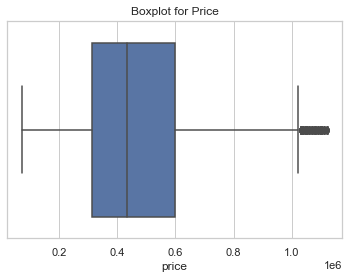

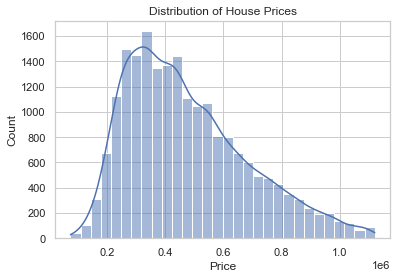

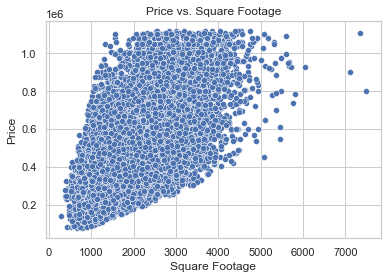

In [21]:
# Boxplot for price
sns.boxplot(x=kc_house_data['price'])
plt.title("Boxplot for Price")
plt.show()

# Histogram for price
sns.histplot(kc_house_data['price'], bins=30, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# Scatterplot for price vs. sqft_living
sns.scatterplot(x=kc_house_data['sqft_living'], y=kc_house_data['price'])
plt.title("Price vs. Square Footage")
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.show()



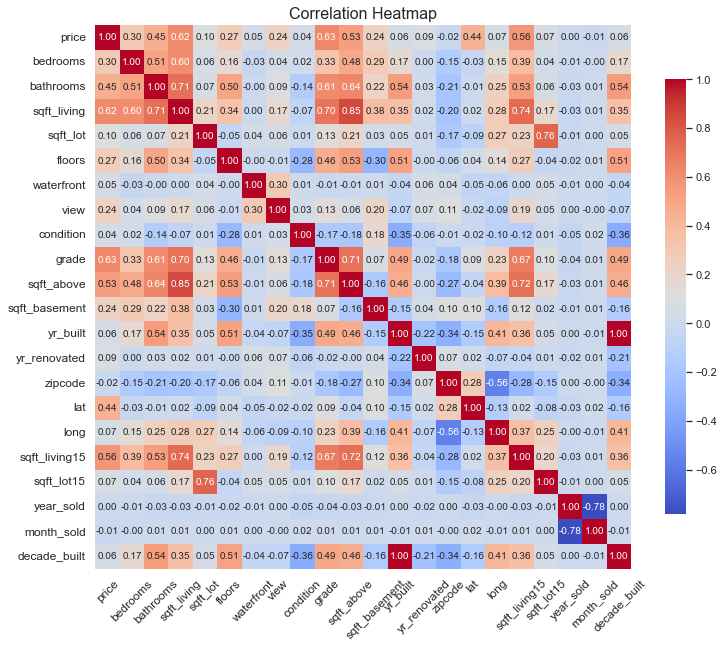

In [22]:

# Correlation heatmap 
plt.figure(figsize=(12, 10))  # Adjust figure size
correlation_matrix = kc_house_data.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            cbar_kws={'shrink': 0.8}, annot_kws={"size": 10})
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()


In [23]:
# Remove aliased columns (sqft_above and sqft_basement)
X.drop(columns=["sqft_above", "sqft_basement"], inplace=True)

# Refit the model
model_refined = sm.OLS(y, X).fit()

# Summary of the updated model
print(model_refined.summary())

# Calculate Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF table
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2661.
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:07:44   Log-Likelihood:            -2.9458e+05
No. Observations:               21613   AIC:                         5.892e+05
Df Residuals:                   21593   BIC:                         5.894e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.575e+07   9.94e+06     -6.612

In [24]:
# Remove 'decade_built' to resolve multicollinearity
X.drop(columns=["decade_built"], inplace=True)

# Refit the model after addressing multicollinearity
model_no_multicollinearity = sm.OLS(y, X).fit()

# Check VIF again
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Summary of the updated model
print(model_no_multicollinearity.summary())

          Feature           VIF
0           const  5.287429e+07
1        bedrooms  1.652159e+00
2       bathrooms  3.271058e+00
3     sqft_living  5.020700e+00
4        sqft_lot  2.100589e+00
5          floors  1.618415e+00
6      waterfront  1.202331e+00
7            view  1.396745e+00
8       condition  1.245817e+00
9           grade  3.347602e+00
10       yr_built  2.430136e+00
11   yr_renovated  1.151392e+00
12        zipcode  1.661530e+00
13            lat  1.165428e+00
14           long  1.771009e+00
15  sqft_living15  2.918544e+00
16     sqft_lot15  2.135234e+00
17      year_sold  2.593970e+00
18     month_sold  2.584124e+00
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2807.
Date:                Sun, 01 Dec 2024   Prob

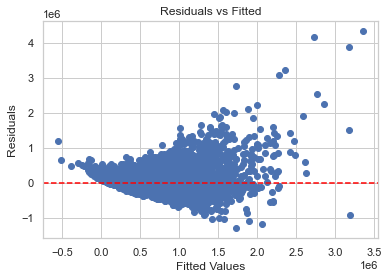

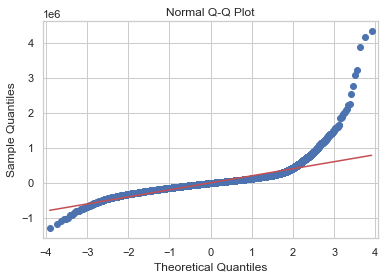

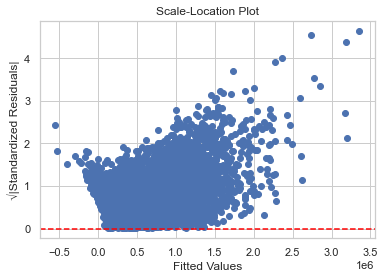

In [25]:
# Residuals vs Fitted plot
plt.scatter(model_no_multicollinearity.fittedvalues, model_no_multicollinearity.resid)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

# Normal Q-Q plot
qqplot(model_no_multicollinearity.resid, line="s")
plt.title("Normal Q-Q Plot")
plt.show()

# Scale-Location plot
standardized_residuals = model_no_multicollinearity.resid / np.sqrt(model_no_multicollinearity.scale)
plt.scatter(model_no_multicollinearity.fittedvalues, np.sqrt(np.abs(standardized_residuals)))
plt.axhline(0, color="red", linestyle="--")
plt.title("Scale-Location Plot")
plt.xlabel("Fitted Values")
plt.ylabel("√|Standardized Residuals|")
plt.show()


In [26]:
# Perform Box-Cox transformation
y_transformed, lambda_value = boxcox(y)

# Fit the model with the transformed response variable
model_transformed = sm.OLS(y_transformed, X).fit()
print(f"Optimal λ for Box-Cox: {lambda_value}")
print(model_transformed.summary())


Optimal λ for Box-Cox: -0.23445394028928604
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     3674.
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:07:54   Log-Likelihood:                 64732.
No. Observations:               21613   AIC:                        -1.294e+05
Df Residuals:                   21594   BIC:                        -1.293e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
co

In [27]:
# Cook's distance to identify influential points
influence = model_transformed.get_influence()
cooks_d = influence.cooks_distance[0]

# Threshold for influential points
threshold = 4 / len(X)
influential_points = np.where(cooks_d > threshold)[0]

# Remove influential points
X_cleaned = X.drop(index=influential_points)
y_cleaned = y.drop(index=influential_points)

# Refit the model after removing influential points
model_cleaned = sm.OLS(y_cleaned, X_cleaned).fit()
print(model_cleaned.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     2966.
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:07:54   Log-Likelihood:            -2.7596e+05
No. Observations:               20488   AIC:                         5.520e+05
Df Residuals:                   20469   BIC:                         5.521e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.798e+07   8.72e+06     -7.799

In [28]:
from statsmodels.tools.eval_measures import bic

# Backward elimination
def backward_elimination(data, target):
    initial_features = data.columns.tolist()
    best_features = initial_features[:]
    while len(best_features) > 0:
        p_values = sm.OLS(target, data[best_features]).fit().pvalues
        worst_feature = p_values.idxmax()
        if p_values[worst_feature] > 0.05:
            best_features.remove(worst_feature)
        else:
            break
    return best_features

selected_features = backward_elimination(X_cleaned, y_cleaned)
print("Selected Features:", selected_features)

# Fit the final model
final_model = sm.OLS(y_cleaned, X_cleaned[selected_features]).fit()
print(final_model.summary())


Selected Features: ['const', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     3336.
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:07:55   Log-Likelihood:            -2.7597e+05
No. Observations:               20488   AIC:                         5.520e+05
Df Residuals:                   20471   BIC:                         5.521e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                               

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


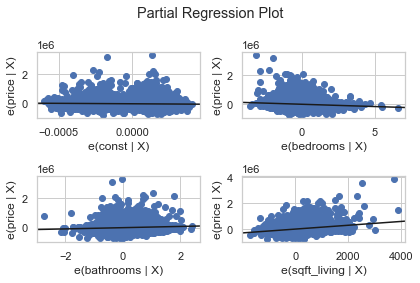

eval_env: 1
eval_env: 1
eval_env: 1


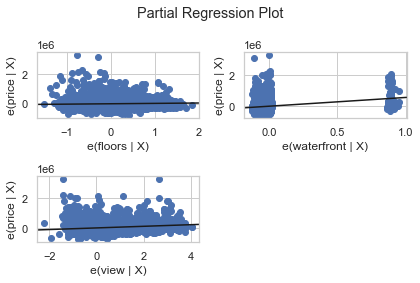

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


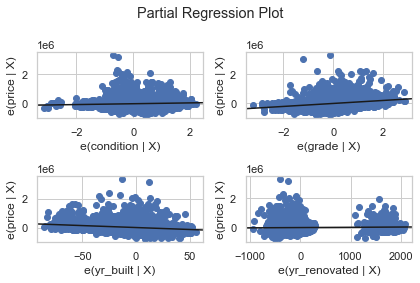

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


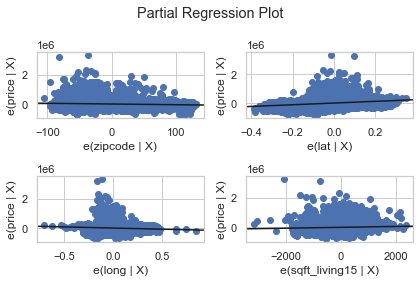

eval_env: 1
eval_env: 1


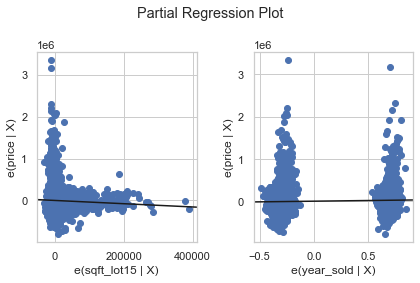

In [32]:
# Ensure group_vars only contains variables present in the model
for i in range(0, len(variables), group_size):
    group_vars = variables[i:i + group_size]
    
    # Validate group variables against model variables
    valid_vars = [v for v in group_vars if v in final_model.model.exog_names]
    if not valid_vars:
        print(f"No valid variables found in group: {group_vars}")
        continue

    # Plot partial regression grid
    sm.graphics.plot_partregress_grid(final_model, exog_idx=valid_vars)
    plt.tight_layout()
    plt.show()
